In [37]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import re
import math

In [2]:
sys.path.insert(0, '/home/llr/cms/wind/cmssw/CMSSW_9_4_2/src/ZZAnalysis/AnalysisStep/test/Python/')

In [3]:
from trainlib.ConfigFileHandler import ConfigFileHandler
from trainlib.ModelCollectionConfigFileHandler import ModelCollectionConfigFileHandler
from trainlib.ConfigFileUtils import ConfigFileUtils

Welcome to JupyROOT 6.10/09


Using TensorFlow backend.


In [4]:
bin_dir = {"Untagged": 0,
            "VBF1j": 1,
            "VBF2j": 2,
            "VHlept": 3,
            "VHhadr": 4,
            "ttHlept": 5,
            "ttHhadr": 6,
            "VHMET": 7}

In [5]:
campaign_workspace = "/data_CMS/cms/wind/"

In [61]:
def weight_func(delta_p, alpha):
    retval = 0.0
    
    if(delta_p > 0.0):
        retval = 1.0 / alpha * math.tanh(alpha * delta_p)
    else:
        retval = delta_p
        
    retval -= 1.0 / alpha
    
    #print "delta_p = " + str(delta_p)
    #print "weight = " + str(retval)
    
    return retval

def cost_func(delta_pi, alpha, m):
    cost = 0.0
        
    for delta_p in delta_pi:
        cost += math.pow(1.0 / alpha, m) - math.pow(weight_func(delta_p, alpha), m)
        
    return cost

In [62]:
def make_comparison_plot(campaign_workspace, campaign_names, punzidata_file, identifier):
    df = pd.DataFrame()

    for campaign_name in campaign_names:
        campaign_dir = campaign_workspace + campaign_name + "/"
    
        for folder, subs, files in os.walk(campaign_dir):
            if re.match(identifier, folder):
                values = {}
            
                punzi_file = folder + "/" + punzidata_file
            
                try:                
                    # try to read the punzi values
                    conf = ConfigFileHandler()
                    conf.load_configuration(punzi_file)
                    
                    delta_pi = []
                    
                    # load the Punzi values for each category
                    for category, bin_number in bin_dir.iteritems():
                        delta_p = float(conf.get_field("Punzi", category))
                        if "Untagged" not in category:
                            delta_pi.append(delta_p - 1)
                        values[category] = [delta_p]
            
                    #benchmark_value = values['VBF1j'][0] + values['VBF2j'][0] + values['VHlept'][0] + values['VHhadr'][0] + values['ttHlept'][0] + values['ttHhadr'][0] + values['VHMET'][0] - 7
                    benchmark_value = cost_func(delta_pi, 8.0, 2)
            
                    values["campaign"] = folder.replace(campaign_workspace, '') + ' (' + str(benchmark_value) + ')'
                    values["benchmark_value"] = benchmark_value
            
                    df = df.append(pd.DataFrame.from_dict(values))
                except (KeyError, IOError):
                    print(punzi_file + " does not exist")

    fig = plt.figure(figsize = (15, 10))
                    
    if len(df) > 0:
        df = df.sort_values('benchmark_value', ascending = False)

        sorted_datacols = sorted(bin_dir.items(), key = lambda x: x[1])
        sorted_datacol_names = [x[0] for x in sorted_datacols]

        punzi_data = df[sorted_datacol_names].as_matrix()
        punzi_data = np.transpose(punzi_data)

        inparam_labels = np.concatenate([[''], df['campaign'].as_matrix()])

        ax = fig.add_subplot(111)
        cax = ax.matshow(punzi_data, interpolation = 'none', cmap = 'RdYlGn', aspect = 0.6, vmin = 0.8, vmax = 1.2)
        fig.colorbar(cax)
        #ax.set_yticklabels(range(len(bin_dir)), [''] + sorted_datacol_names)
        #ax.set_xticklabels(range(len(df)), inparam_labels, rotation = 'vertical')
        ax.set_yticklabels([''] + sorted_datacol_names)
        ax.set_xticklabels(inparam_labels, rotation = 'vertical')
        ax.xaxis.tick_bottom()
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        #plt.tight_layout()
        plt.title("Punzi purity ratio [" + punzidata_file + "]")
        #plt.savefig(statistics_dir + "punzi_input_sweep.pdf")
        #plt.show()

    return fig

In [65]:
%%capture
plot_20 = make_comparison_plot(campaign_workspace, ["180420_Adam_largebatch_reopt"], "Mor18_punzi_comp.conf", ".*comp.*test.*")

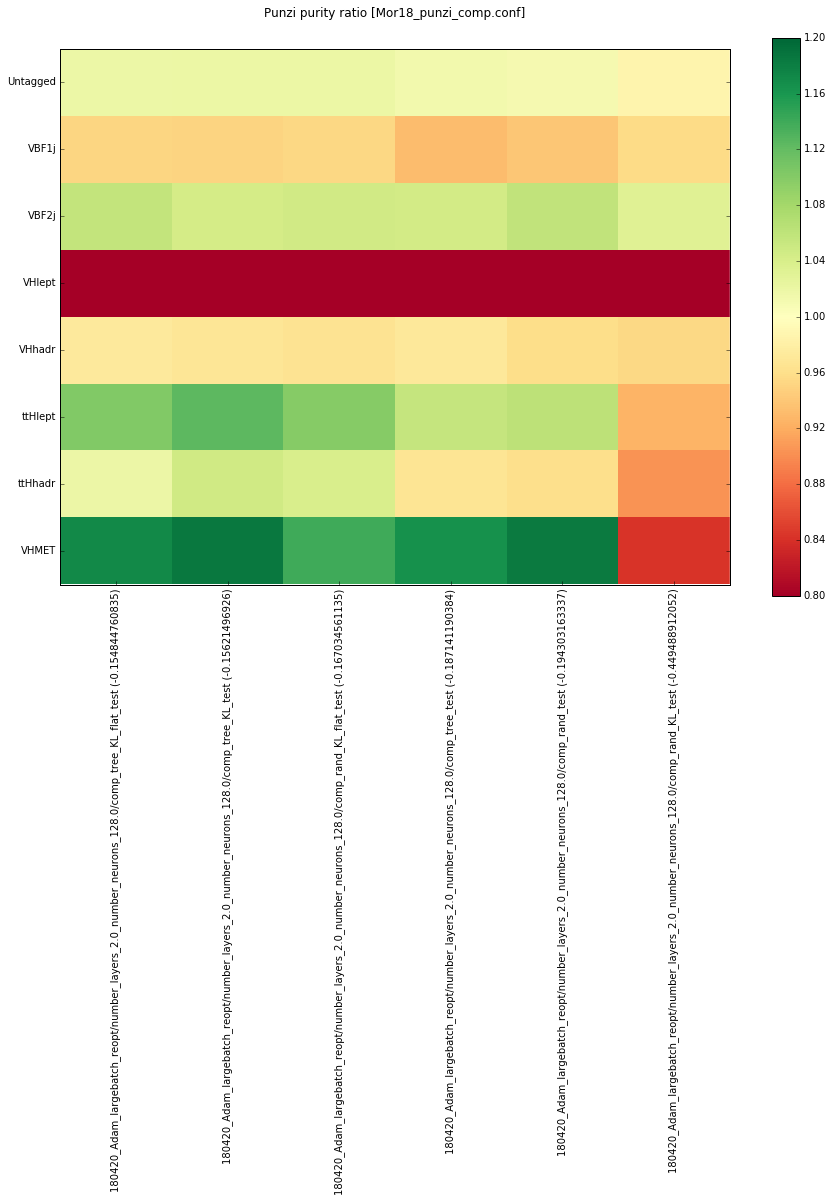

In [66]:
plt.show()

In [72]:
%%capture
plot_20 = make_comparison_plot(campaign_workspace, ["180420_Adam_optimized_inputs_128_reopt"], "Mor18_punzi_comp.conf", ".*comp.*test.*")

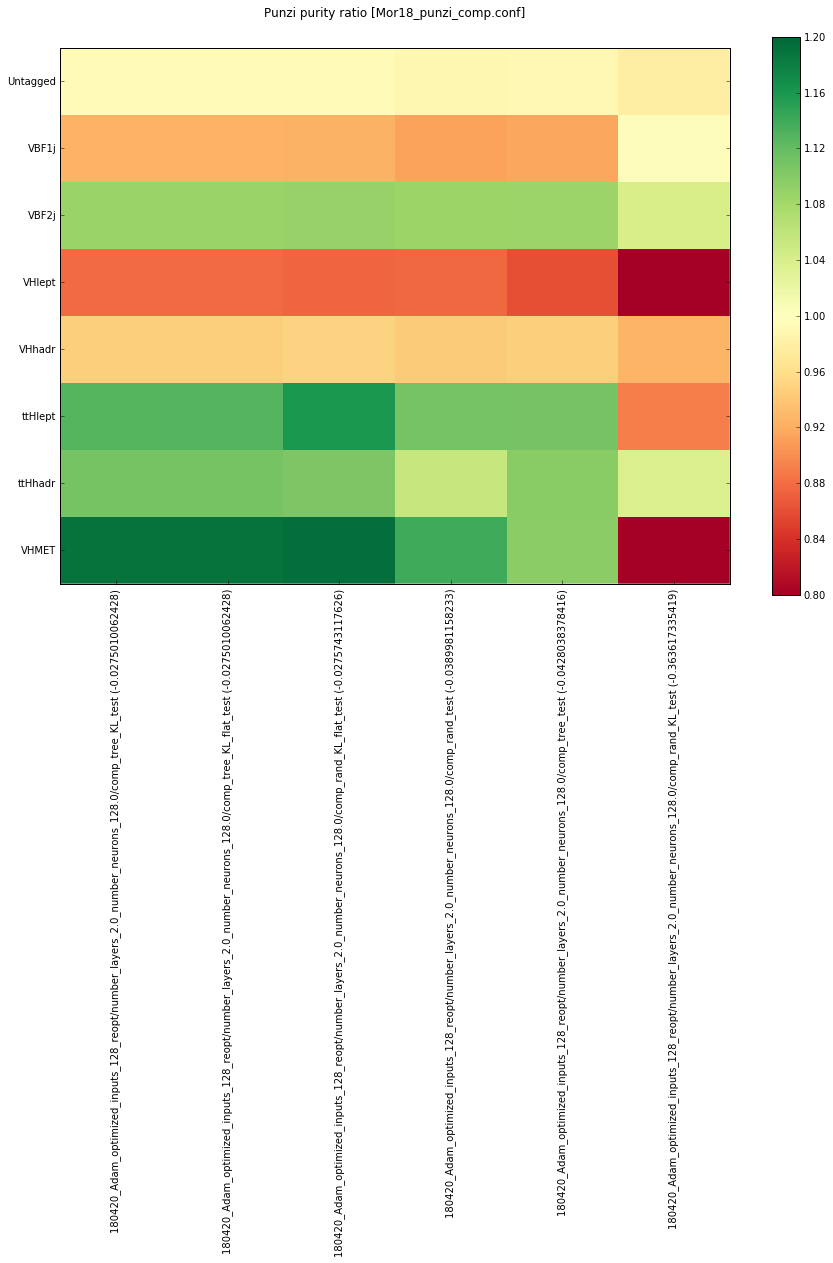

In [73]:
plt.show()

In [69]:
%%capture
plot_20 = make_comparison_plot(campaign_workspace, ["180420_Adam_optimized_inputs_64_reopt"], "Mor18_punzi_comp.conf", ".*comp.*test.*")

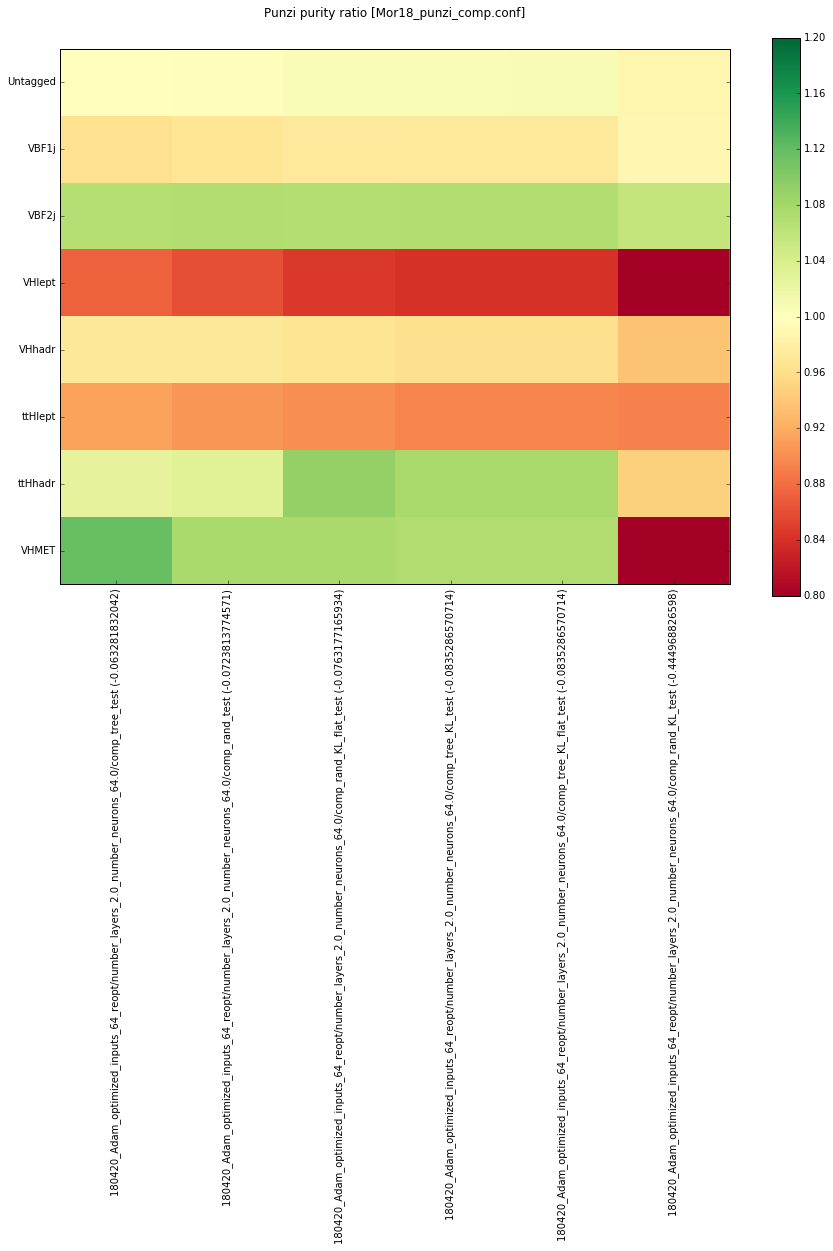

In [70]:
plt.show()